In [1]:
# Prepare
import pandas as pd
import os, requests, json
import numpy as np
os.chdir('/Users/denis/Documents/Projects/hiv-analysis/hiv-signature-analysis')
%load_ext rpy2.ipython
%R source('/Users/denis/Documents/Projects/scripts/Support.R')
%R library(gplots)

/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘gplots’


  warnings.warn(x, RRuntimeWarning)
/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:stats’:

    lowess


  warnings.warn(x, RRuntimeWarning)


array(['gplots', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

# Analysis of Batch Effect Removal

## Overview

The purpose of this notebook is to investigate the effect of the batch effect removal algorithm on the HIV-infected podocyte cell-line data.

## Computation

In [2]:
# Infiles
infiles = ['f2-normalized_expression_data.dir/podocyte_cell_line-vst.txt', 'f3-adjusted_expression_data.dir/podocyte_cell_line-vst_corrected.txt']

# Read data
vstDataframe = pd.read_table(infiles[0]).set_index('gene_symbol')

# Read data
vstDataframeCorrected = pd.read_table(infiles[1]).set_index('gene_symbol')

# Create annotation dataframe
annotationDataframe = pd.DataFrame([[x, x.split('.')[0], x.split('.')[1]] for x in vstDataframe.columns], columns=['sample_id','timepoint','batch']).set_index('sample_id')

In [3]:
%%R
plotPCA <- function(expressionDataframe, sampleLabels, main='', legendTitle = '', PCs=c('PC1', 'PC2'))
{
    # Run PCA
    pcaRes <- runPCA(expressionDataframe)

    # Get plot matrix
    plotMatrix <- pcaRes$x

    # Get color legend
    sampleNames <- rownames(plotMatrix)
    colorLegend <- getLegend(sampleNames, sampleLabels)#, colors=c('black','red','blue'))

    # Plot
    plot(plotMatrix[,PCs],
         col=colorLegend$colors,
         xlab=pcaRes$varLabels[PCs[1]],
         ylab=pcaRes$varLabels[PCs[2]],
         main=main)

    # Legend
    legend('topright', legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

In [4]:
%%R
plotHeatmap <- function(expressionDataframe, sampleLabels, nGenes=1000, main='', pos=c(0, 0.7), legendTitle='Batch', method='complete')
{
    # Get gene variance
    geneVariance <- sort(apply(expressionDataframe, 1, var), decreasing=TRUE)

    # Get top genes
    topGenes <- names(geneVariance)[1:nGenes]

    # Get matrix
    plotMatrix <- as.matrix(expressionDataframe[topGenes,])

    # Get color legend
    sampleNames <- colnames(expressionDataframe)
    colorLegend <- getLegend(sampleNames, sampleLabels)

    # Plot margins
    par(mar=c(5,4,0,2))

    # Plot
    heatmap.2(plotMatrix,
              col=colorRampPalette(c('black','yellow','red')),
              trace='none',
              labRow = '',
              xlab = paste0(ncol(plotMatrix), ' samples'),
              ylab=paste0('Top ', nrow(plotMatrix), ' most variable genes'),
              mar=c(5,2),
              srtCol=45,
              key.title='Color Key',
              key.xlab='Expression level (VST)',
              ColSideColors=colorLegend$colors,
              hclustfun = function(x) hclust(x, method=method),
              main=main)

    # Add legend
    legend(pos[1], pos[2], legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

## Plots

### PCA

#### Batch Effect

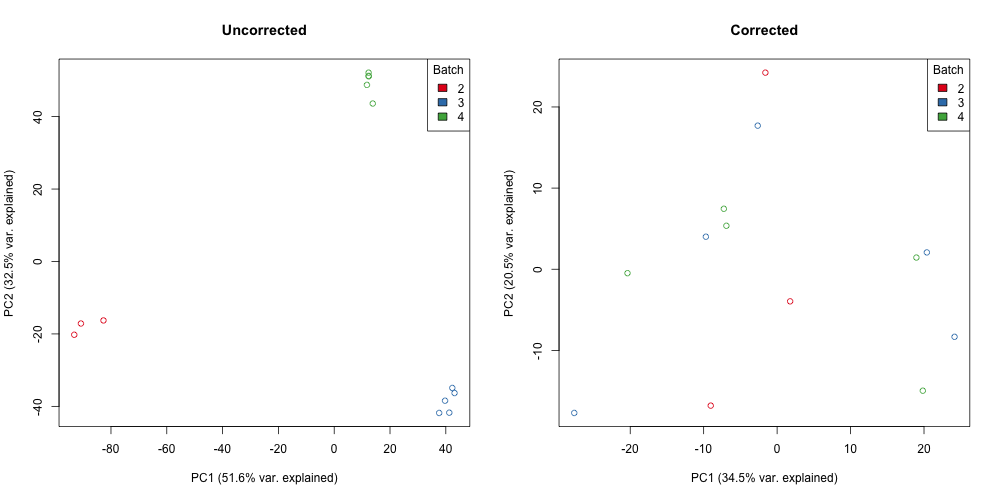

In [5]:
%%R -i vstDataframe,vstDataframeCorrected,annotationDataframe -h 500 -w 1000
# Set grid
par(mfrow=c(1,2))

# Plot
plotPCA(vstDataframe, annotationDataframe[colnames(vstDataframe), 'batch'], 'Uncorrected', 'Batch')
plotPCA(vstDataframeCorrected, annotationDataframe[colnames(vstDataframe), 'batch'], 'Corrected', 'Batch')

#### Conditions

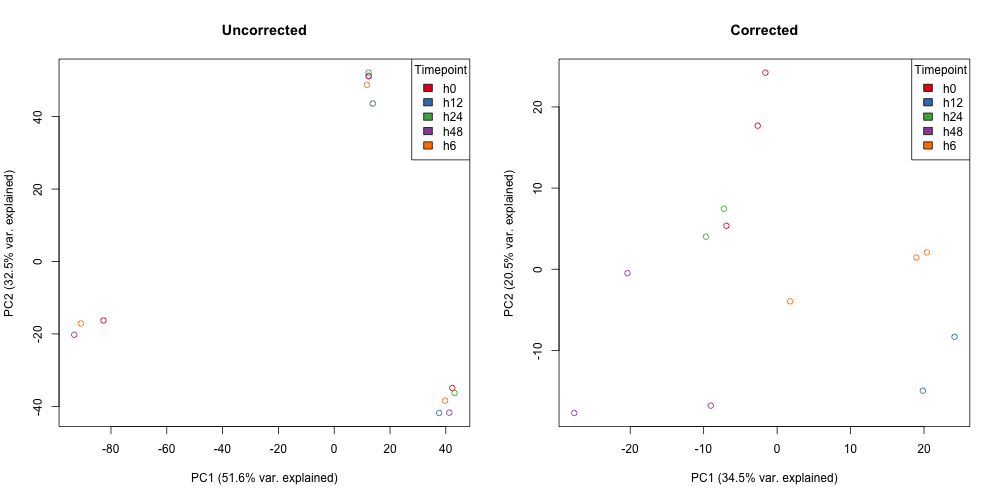

In [6]:
%%R -h 500 -w 1000
# Set grid
par(mfrow=c(1,2))

# Plot
plotPCA(vstDataframe, annotationDataframe[colnames(vstDataframe), 'timepoint'], 'Uncorrected', 'Timepoint')
plotPCA(vstDataframeCorrected, annotationDataframe[colnames(vstDataframe), 'timepoint'], 'Corrected', 'Timepoint')

### Heatmap

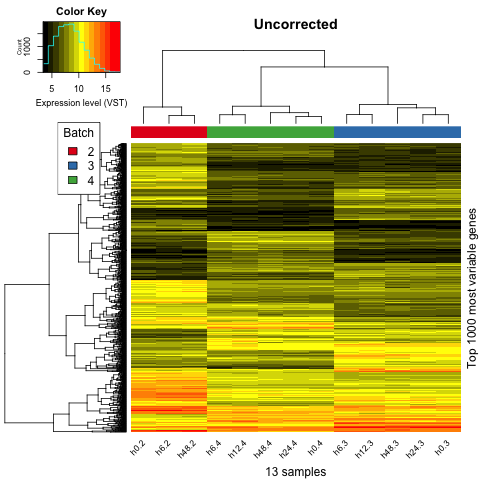

In [7]:
%%R
plotHeatmap(vstDataframe, annotationDataframe[colnames(vstDataframe), 'batch'], main='Uncorrected')

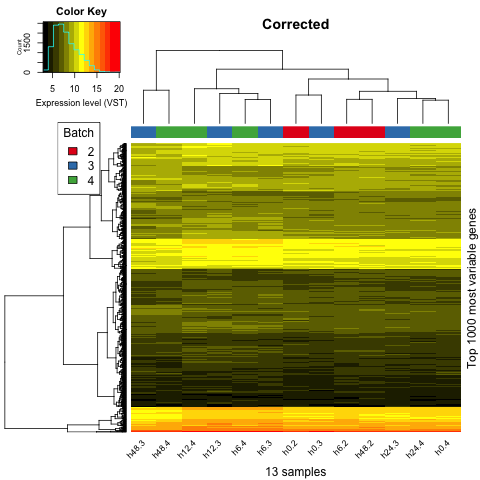

In [8]:
%%R
plotHeatmap(vstDataframeCorrected, annotationDataframe[colnames(vstDataframe), 'batch'], main='Corrected')

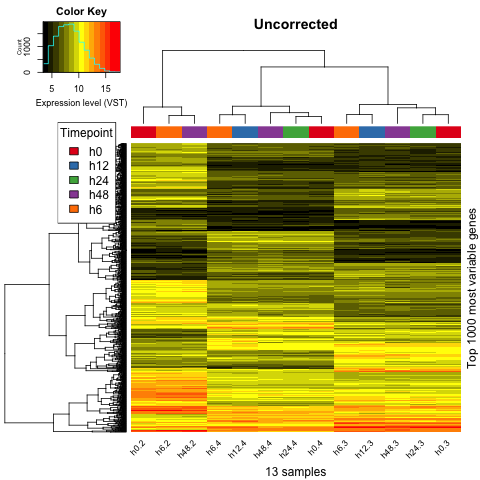

In [9]:
%%R
plotHeatmap(vstDataframe, annotationDataframe[colnames(vstDataframe), 'timepoint'], main='Uncorrected', legendTitle='Timepoint')

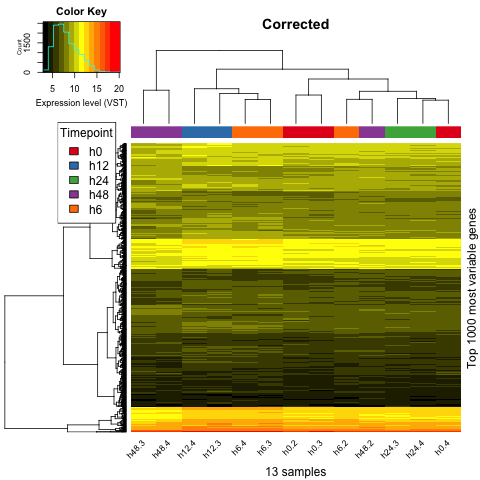

In [10]:
%%R
plotHeatmap(vstDataframeCorrected, annotationDataframe[colnames(vstDataframeCorrected), 'timepoint'], main='Corrected', legendTitle='Timepoint', nGenes=1000)

## Enrichment Analysis

In [11]:
# Define Enrichr API
def enrichr_get_url(genes, meta=''):
    """POST a gene list to Enrichr server and return the list ids"""
    genes_str = '\n'.join(genes)
    payload = {
        'list': (None, genes_str),
        'description': (None, meta)
    }
    # POST genes to the /addList endpoint
    response = requests.post("%s/addList" % 'http://amp.pharm.mssm.edu/Enrichr', files=payload)
    list_ids = json.loads(response.text)

    # Return URL
    result_url = 'http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=' + list_ids['shortId']
    return result_url

In [12]:
# Set number of genes
nGenes = 500

# Get variable genes
variableGeneDict = {}
variableGeneDict['uncorrected'] = vstDataframe.apply(np.var, 1).sort_values(ascending=False).index.tolist()[:nGenes]
variableGeneDict['corrected'] = vstDataframeCorrected.apply(np.var, 1).sort_values(ascending=False).index.tolist()[:nGenes]

In [13]:
# Get Enrichr links
enrichrLinkDict = {x:enrichr_get_url(variableGeneDict[x]) for x in variableGeneDict.keys()}

In [14]:
# Convert to dataframe
enrichrLinkDataframe = pd.DataFrame.from_dict(enrichrLinkDict, orient='index').rename(columns={0:'Enrichr_link'})

# Display
pd.options.display.max_colwidth = 100
enrichrLinkDataframe

,Enrichr_link
uncorrected,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18ums
corrected,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18umt
